# 02 - Cell Type Annotation

This notebook demonstrates clustering and cell type annotation for single-cell data.

## Overview

Steps include:
1. Load preprocessed data
2. Neighbor graph construction
3. Clustering (Leiden algorithm)
4. UMAP visualization
5. Marker gene identification
6. Cell type annotation

## Setup

In [19]:
import os
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

# Set working directory to notebook location
notebook_dir = r'z:\thornes\Pavlicev_lab_rotation\FLUXestimator\notebooks'
os.chdir(notebook_dir)
print(f"Working directory: {os.getcwd()}")

# Configure scanpy
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, facecolor='white', figsize=(10, 10))

print(f"Scanpy version: {sc.__version__}")

Working directory: z:\thornes\Pavlicev_lab_rotation\FLUXestimator\notebooks
Scanpy version: 1.11.5


C:\Users\dell\AppData\Local\Temp\ipykernel_40064\812040750.py:18: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('scanpy')` instead
  print(f"Scanpy version: {sc.__version__}")


## Load Configuration and Data

In [36]:
# Load configuration
with open('../config/analysis_config.yaml', 'r') as f:
    config = yaml.safe_load(f)

In [46]:
# Load preprocessed data
adata = sc.read_h5ad('../data/processed/preprocessed_data.h5ad')

print(f"Loaded data: {adata.shape[0]} cells x {adata.shape[1]} genes")
adata

# Get normalized log-transformed expression as DataFrame
expr_df = pd.DataFrame(
    adata.X.toarray() if hasattr(adata.X, 'toarray') else adata.X,
    index=adata.obs_names,  # Cell barcodes as rows
    columns=adata.var_names  # Gene names as columns
)

# Display first few rows and columns
print(f"Expression matrix shape: {expr_df.shape}")
print(f"Cells: {expr_df.shape[0]}, Genes: {expr_df.shape[1]}")

#trasnpose matrix to have gees as rows and cells as columns
expr_df_transposed = expr_df.T

# Save to CSV
expr_df_transposed.to_csv('../data/processed/expression_matrix.csv')
print("Expression matrix saved to '../data/processed/expression_matrix.csv'")
expr_df_transposed.iloc[:5, :5]  # Display first 5 genes and 5 cells


Loaded data: 7839 cells x 23542 genes
Expression matrix shape: (7839, 23542)
Cells: 7839, Genes: 23542
Expression matrix saved to '../data/processed/expression_matrix.csv'


AAACCCAAGGGTGAAA-1  AAACCCAAGTTTCAGC-1  AAACCCACAAACTAAG-1  \
Xkr4               0.144935           -0.461655           -0.461655   
Gm1992            -0.099427           -0.099427           -0.099427   
Gm19938            3.113176           -0.173639           -0.173639   
Gm37381           -0.024975           -0.024975           -0.024975   
Rp1               -0.046221           -0.046221           -0.046221   

         AAACCCACAGAAACCG-1  AAACCCACAGGTTTAC-1  
Xkr4               0.826666           -0.461655  
Gm1992            -0.099427           -0.099427  
Gm19938           -0.173639           -0.173639  
Gm37381           -0.024975           -0.024975  
Rp1               -0.046221           -0.046221

## Neighborhood Graph

Construct k-nearest neighbor graph in PCA space.

In [51]:
# Compute neighborhood graph
sc.pp.neighbors(
    adata,
    n_neighbors=config['cell_annotation']['n_neighbors'],
    n_pcs=config['cell_annotation']['n_pcs']
)

print("Neighborhood graph computed")

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
Neighborhood graph computed


## Clustering

Apply Leiden clustering algorithm.

In [52]:
# Leiden clustering
sc.tl.leiden(
    adata,
    # resolution=config['cell_annotation']['resolution'],
    resolution=0.8,
    random_state=config['compute']['random_state']
)

print(f"Identified {adata.obs['leiden'].nunique()} clusters")
print(adata.obs['leiden'].value_counts().sort_index())

# for res in [0.4, 0.6, 0.8, 1.0, 1.2]:
#     sc.tl.leiden(adata, resolution=res, key_added=f'leiden_{res}')
#     print(f"Resolution {res}: {adata.obs[f'leiden_{res}'].nunique()} clusters")

running Leiden clustering
    finished: found 21 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)
Identified 21 clusters
leiden
0     1220
1     1116
2     1081
3      748
4      571
5      471
6      417
7      364
8      314
9      266
10     229
11     219
12     200
13     186
14     140
15     108
16      60
17      45
18      39
19      30
20      15
Name: count, dtype: int64


## UMAP Visualization

Compute UMAP embedding for visualization.

In [53]:
# Compute UMAP
sc.tl.umap(
    adata,
    min_dist=config['visualization']['umap_min_dist'],
    spread=config['visualization']['umap_spread'],
    random_state=config['compute']['random_state']
)

print("UMAP embedding computed")

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:21)
UMAP embedding computed


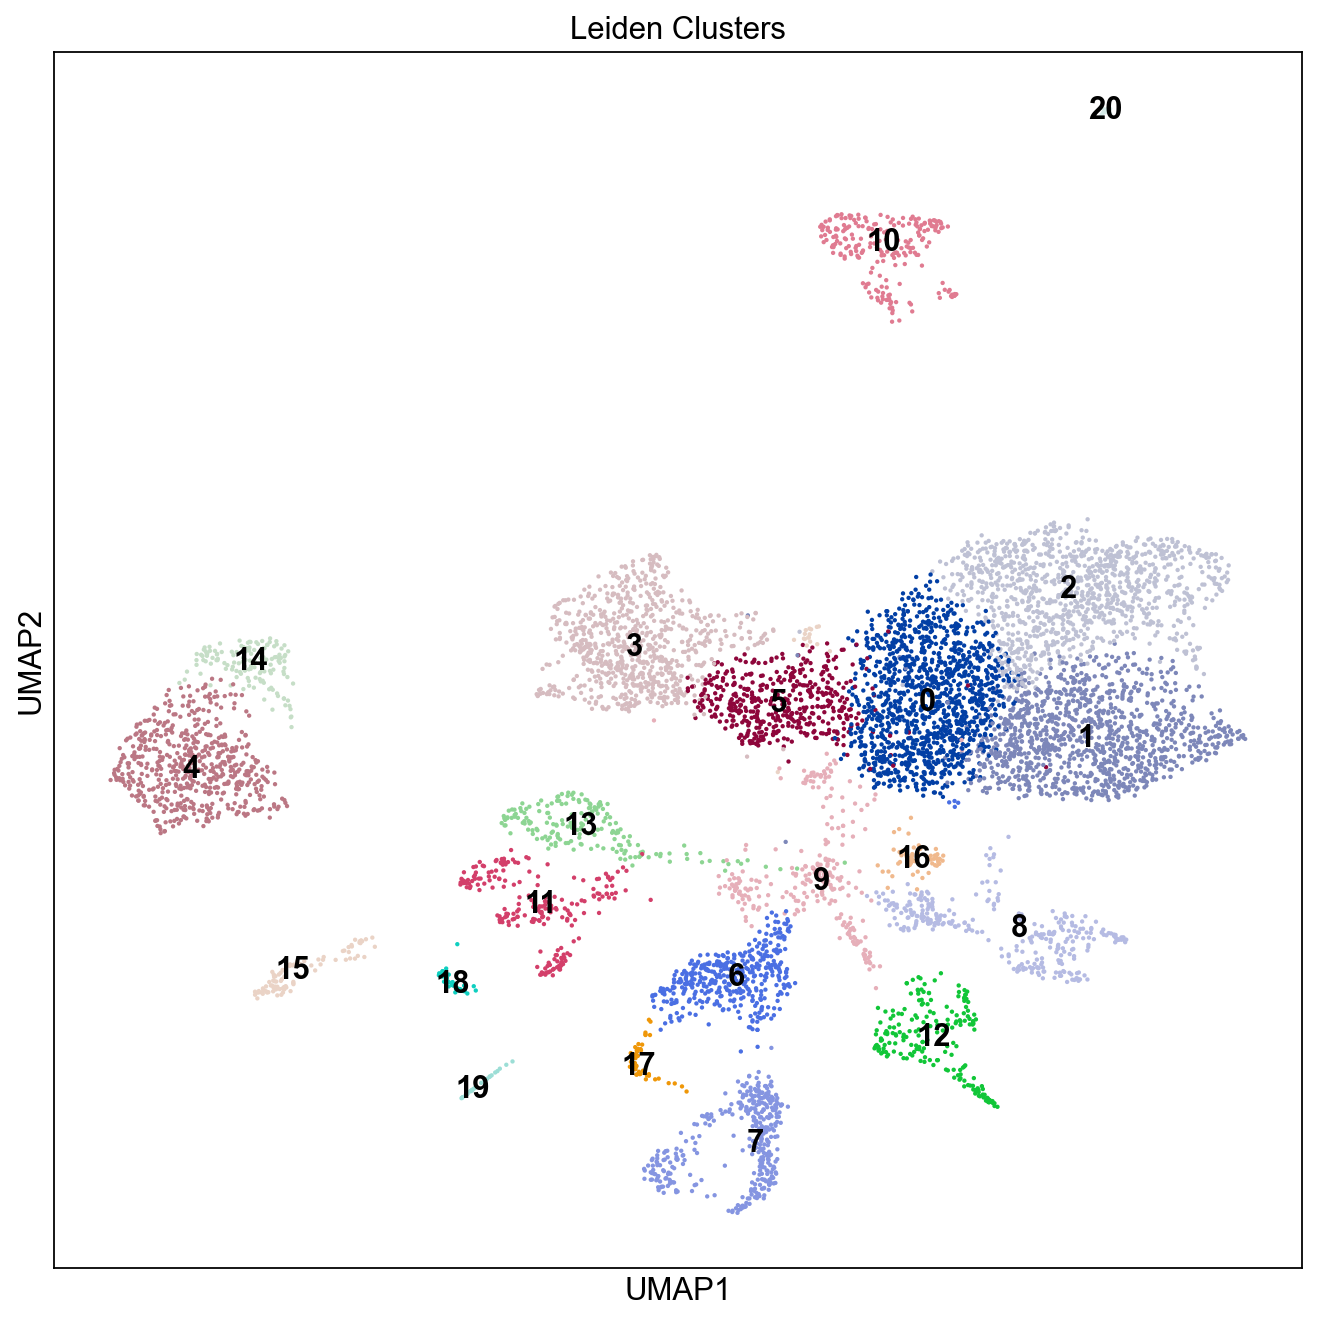

In [54]:
# Visualize clusters
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='Leiden Clusters')

## Marker Gene Identification

Find differentially expressed genes for each cluster.

In [55]:
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)

# Find marker genes for each cluster
sc.tl.rank_genes_groups(
    adata,
    groupby='leiden',
    method='wilcoxon',
    key_added='rank_genes'
)

print("Marker gene analysis complete")

ranking genes
    finished: added to `.uns['rank_genes']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:46)
Marker gene analysis complete


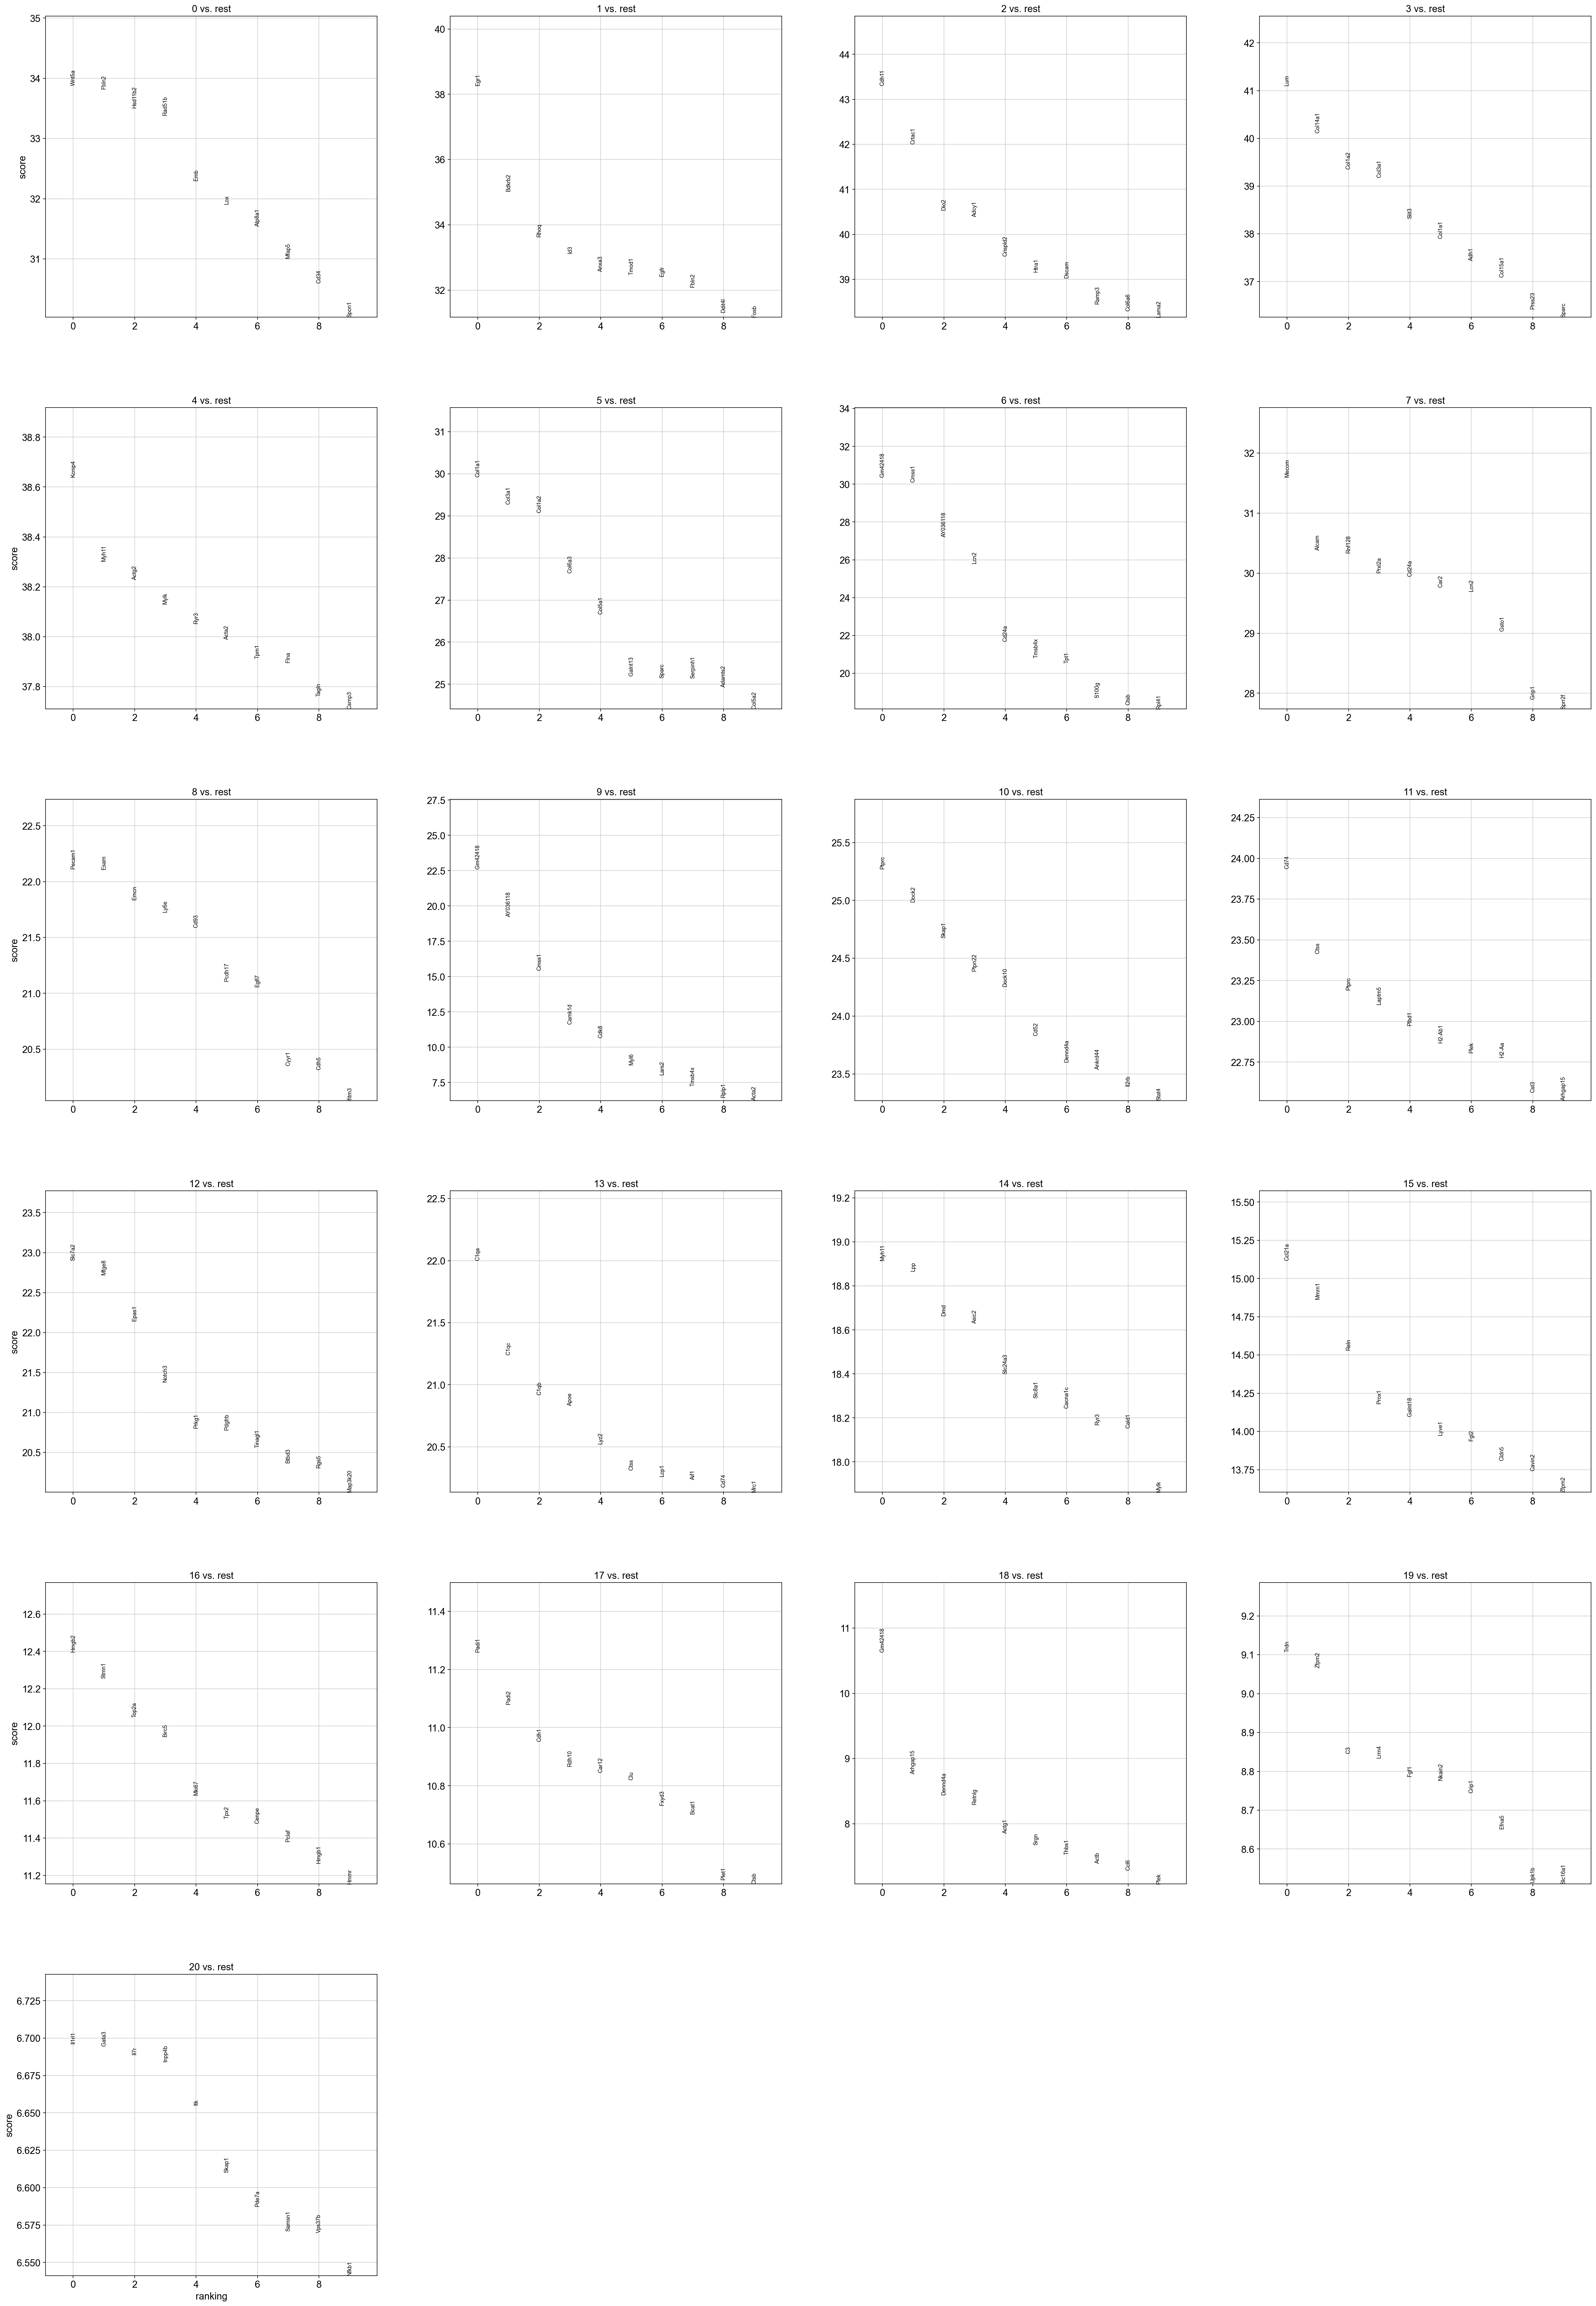

In [56]:
# Visualize top marker genes
sc.pl.rank_genes_groups(adata, n_genes=10, key='rank_genes', sharey=False)

In [57]:
# Get top marker genes as dataframe
marker_df = sc.get.rank_genes_groups_df(adata, group=None, key='rank_genes')
# save matrix
marker_df.to_csv('../results/tables/marker_genes.csv', index=False)
marker_df.head(20)

group     names     scores  logfoldchanges          pvals      pvals_adj
0      0     Wnt5a  33.880234             NaN  1.302466e-251  3.066266e-247
1      0     Fbln2  33.822941             NaN  9.074149e-251  1.068118e-246
2      0   Hsd11b2  33.510155             NaN  3.428642e-246  2.690569e-242
3      0    Rad51b  33.387623             NaN  2.073383e-244  1.220289e-240
4      0       Emb  32.301193             NaN  6.730299e-229  3.168894e-225
5      0       Lox  31.911453             NaN  1.852055e-223  7.266847e-220
6      0    Atp8a1  31.542126             NaN  2.299254e-218  7.732721e-215
7      0     Mfap5  31.011806             NaN  3.736607e-211  1.099590e-207
8      0      Cd34  30.599463             NaN  1.244295e-205  3.254800e-202
9      0     Spon1  30.032185             NaN  3.730873e-198  8.783221e-195
10     0     Sned1  29.613148             NaN  1.011989e-192  2.165841e-189
11     0      Fbn1  29.574854             NaN  3.147141e-192  6.174166e-189
12     0     Radil  29.485159             NaN  4.462236e-191  8.080767e-188
13     0      Rorb  29.447847             NaN  1.341415e-190  2.255685e-187
14     0     Acss3  29.297527             NaN  1.115152e-188  1.750193e-185
15     0  Adamts12  29.025301             NaN  3.155142e-185  4.642398e-182
16     0    Atp8b1  28.844595             NaN  5.922804e-183  8.202038e-180
17     0    Col4a4  28.820345             NaN  1.192790e-182  1.560037e-179
18     0     Matn2  28.813005             NaN  1.474043e-182  1.826417e-179
19     0     Anxa3  28.708097             NaN  3.023136e-181  3.558533e-178

## Cell Type Annotation

Annotate clusters based on known marker genes.

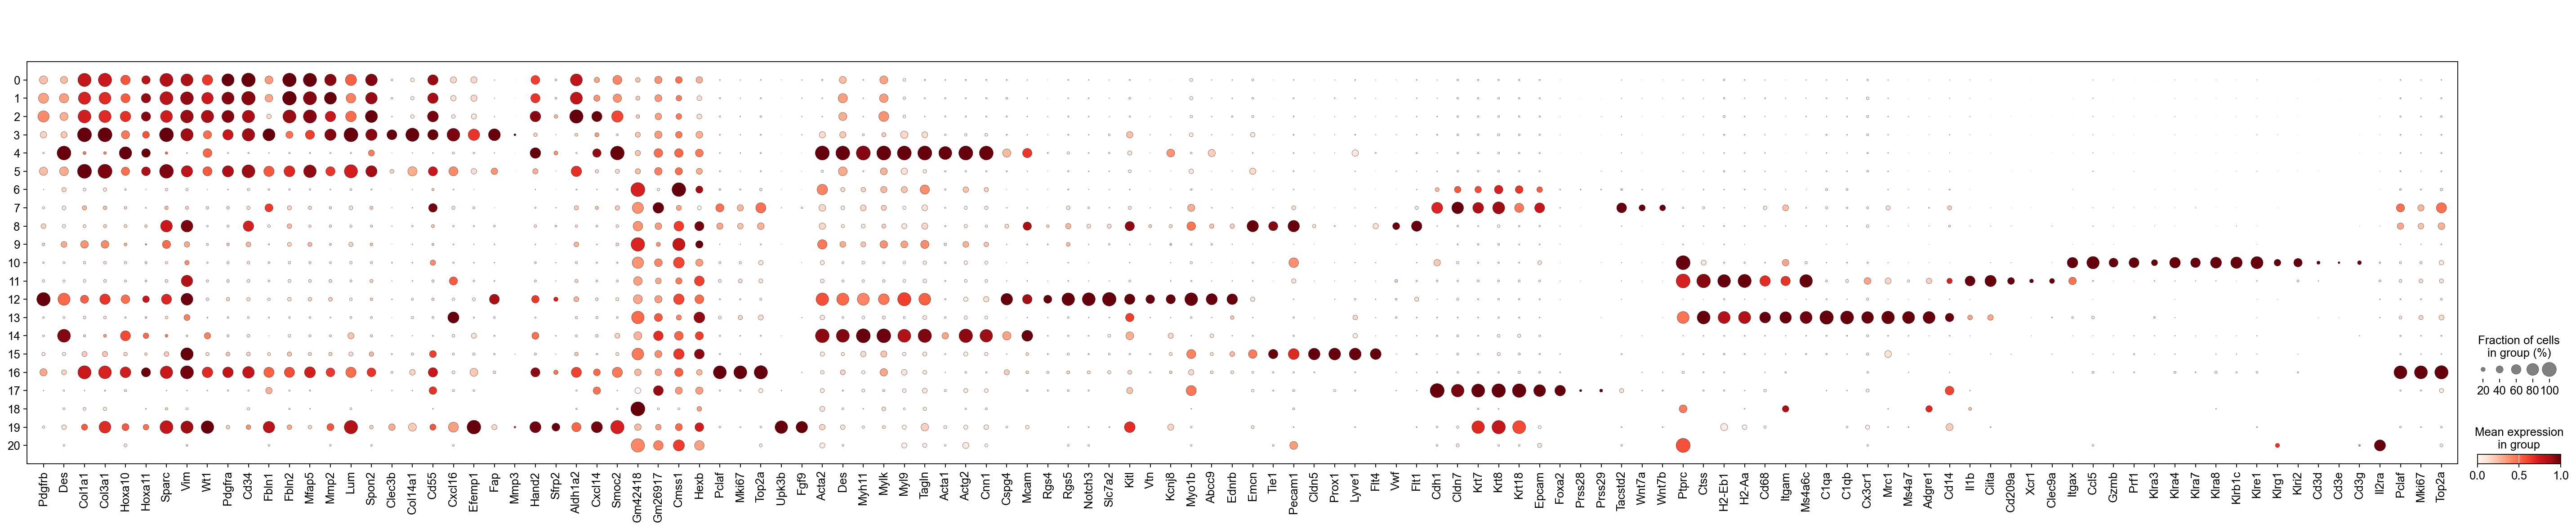

In [58]:
# Define marker genes for reproductive tissue cell types
marker_genes = config['cell_annotation']['marker_genes']

# Visualize marker gene expression
all_markers = [gene for genes in marker_genes.values() for gene in genes]
available_markers = [g for g in all_markers if g in adata.var_names]

if len(available_markers) > 0:
    sc.pl.dotplot(
        adata,
        var_names=available_markers[:150],  # Show first 100 available markers
        groupby='leiden',
        standard_scale='var'
    )
else:
    print("Note: Marker genes not found in dataset.")

In [95]:
# Manual annotation based on marker gene expression

cluster_annotations = {
    '0': 'Fibroblast Cells',
    '1': 'Fibroblast Cells',
    '2': 'Inner Fibroblast Cells',
    '3': 'Fibroblasts: Clec3b+ (outer/basal)',
    '4': 'Myometrium: Smooth Muscle Cells',
    '5': 'Fibroblast Cells',
    '6': 'Ignore',
    '7': 'Luminal Epithelial Cells',
    '8': 'Vascular Endothelium Cells',
    '9': 'Ignore',
    '10': 'Natural Killer Cells',
    '11': 'Dendritic Monocyte Cells',
    '12': 'Perivascular/Mural Cells',
    '13': 'Macrophage Cells',
    '14': 'Myometrium: Perivascular/Muscle Cells',
    '15': 'Lymphatic Endothelial Cells',
    '16': 'Proliferating Fibroblast Cells',
    '17': 'Epithelial Cells',
    '18': 'Inconclusive',
    '19': 'Mesothelial Cells',
    '20': 'T Cells'
}

# Map cluster IDs to cell type names
adata.obs['cell_type'] = adata.obs['leiden'].map(cluster_annotations)

# For unmapped clusters, keep cluster ID
adata.obs['cell_type'] = adata.obs['cell_type'].fillna('Cluster ' + adata.obs['leiden'].astype(str))

print("Cell type annotations:")
print(adata.obs['cell_type'].value_counts())

Cell type annotations:
cell_type
Fibroblast Cells                         2807
Inner Fibroblast Cells                   1081
Fibroblasts: Clec3b+ (outer/basal)        748
Ignore                                    683
Myometrium: Smooth Muscle Cells           571
Luminal Epithelial Cells                  364
Vascular Endothelium Cells                314
Natural Killer Cells                      229
Dendritic Monocyte Cells                  219
Perivascular/Mural Cells                  200
Macrophage Cells                          186
Myometrium: Perivascular/Muscle Cells     140
Lymphatic Endothelial Cells               108
Proliferating Fibroblast Cells             60
Epithelial Cells                           45
Inconclusive                               39
Mesothelial Cells                          30
T Cells                                    15
Name: count, dtype: int64


Plotting 7117 cells (excluded 722 unassigned cells)


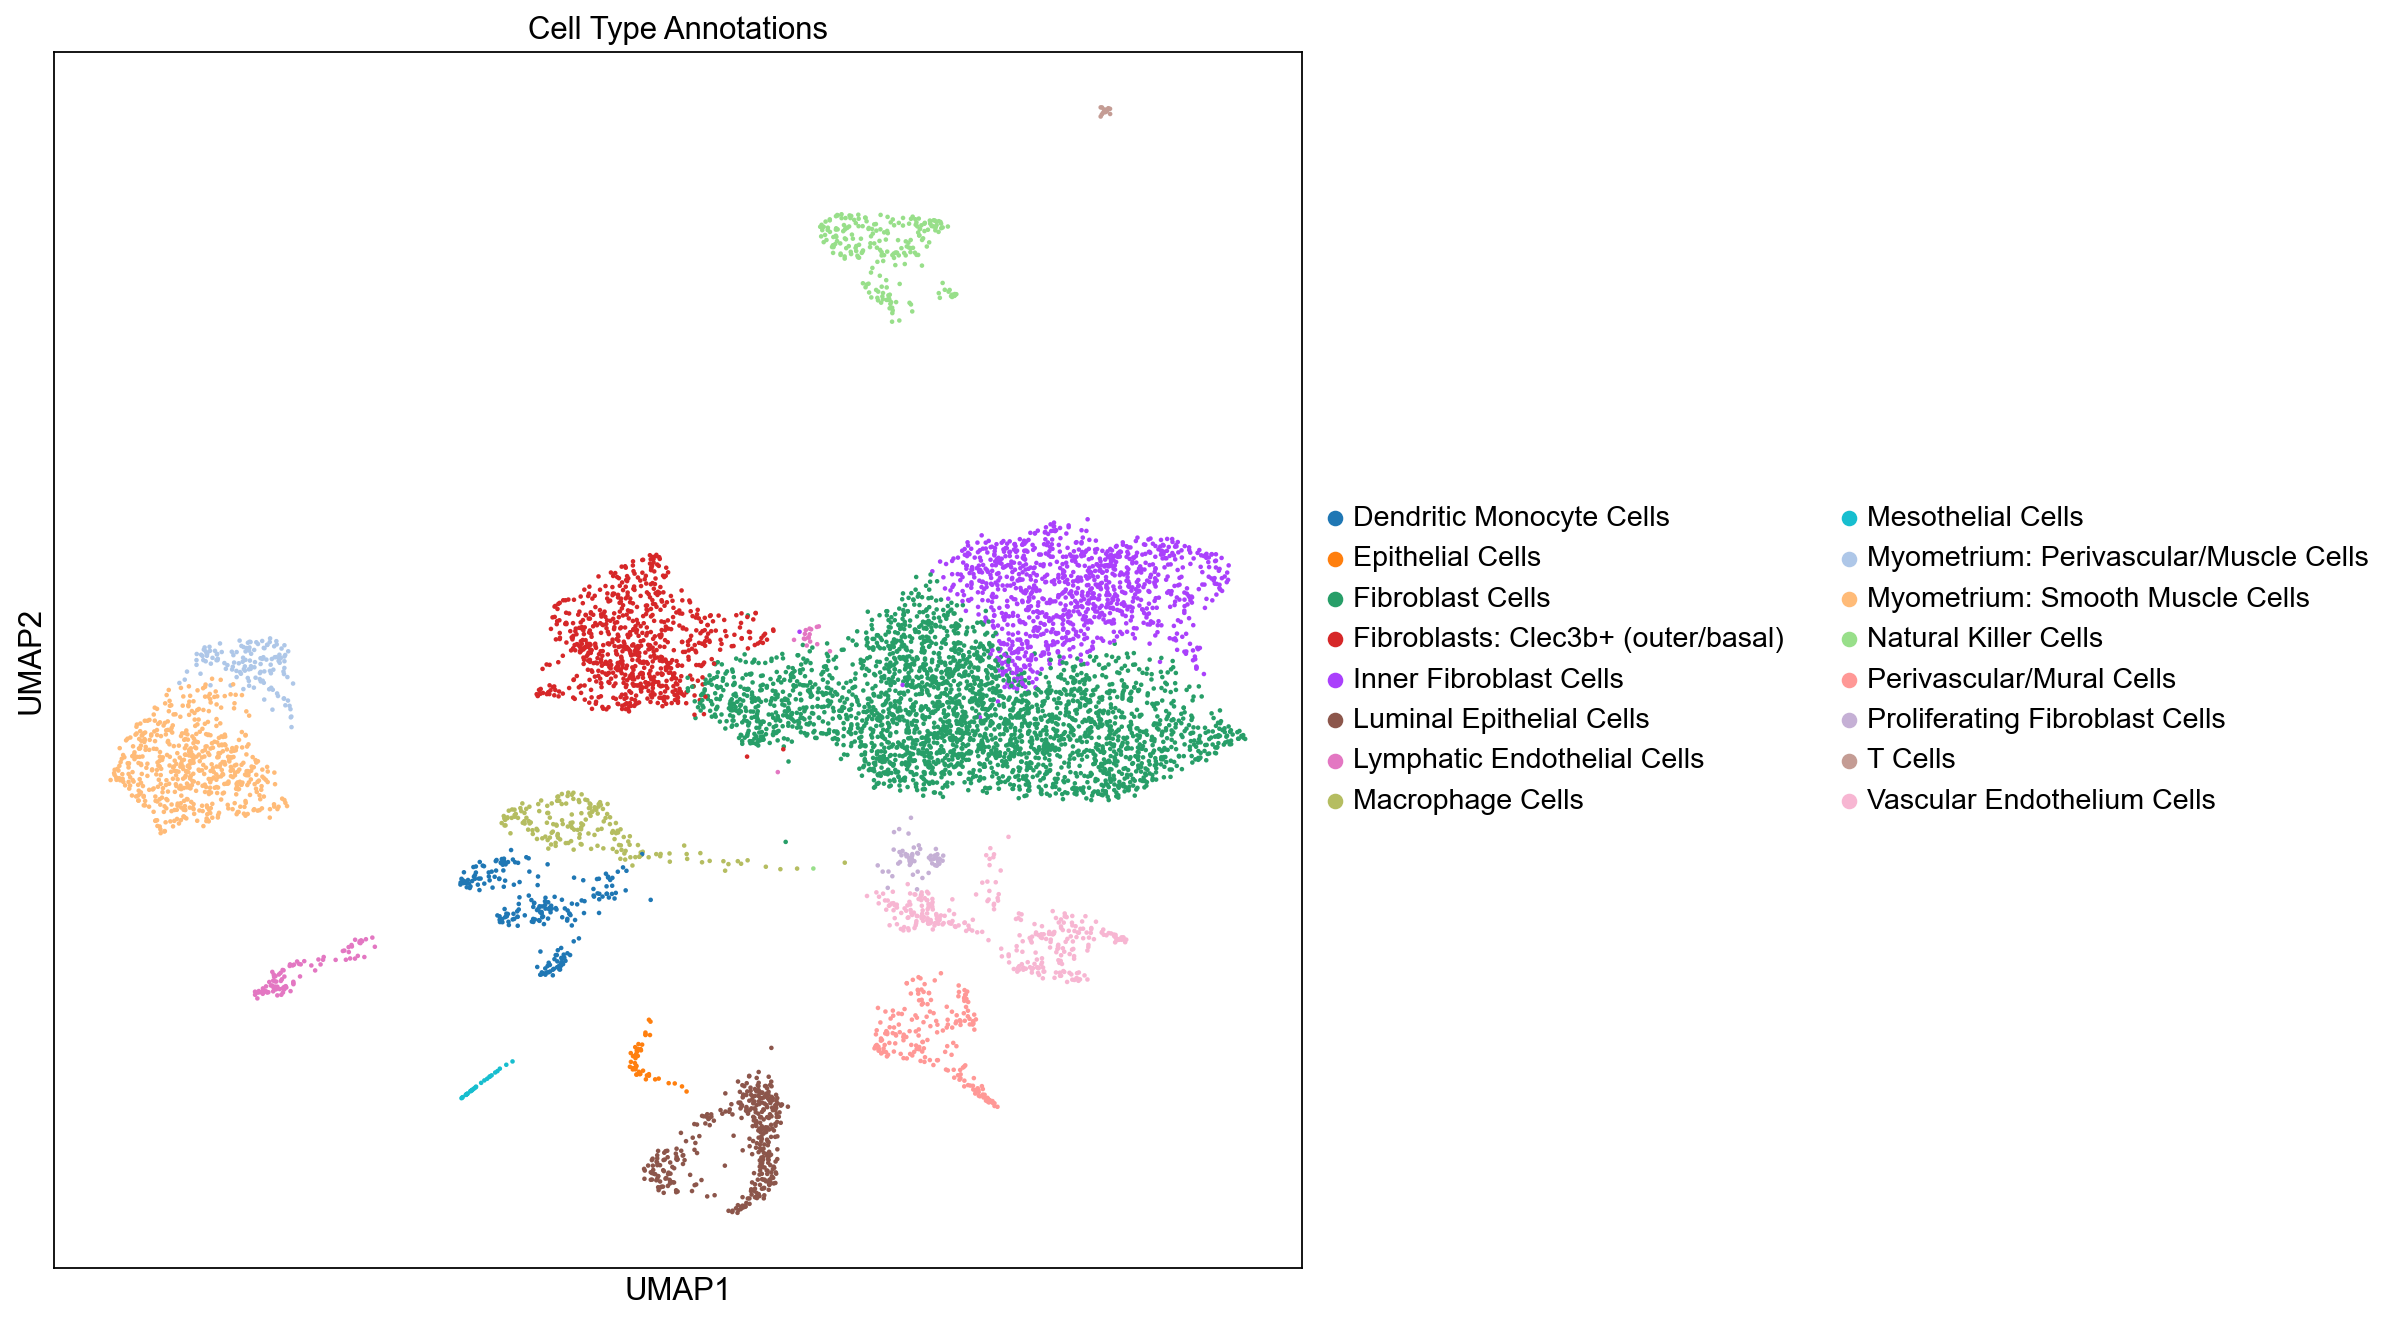

In [96]:
# Visualize cell types

# Filter out cells marked as 'Ignore' or 'Inconclusive'
adata_filtered = adata[~adata.obs['cell_type'].isin(['Ignore', 'Inconclusive'])].copy()

print(f"Plotting {adata_filtered.n_obs} cells (excluded {adata.n_obs - adata_filtered.n_obs} unassigned cells)")

sc.pl.umap(adata_filtered, color='cell_type', title='Cell Type Annotations')

## Quality Checks

Verify cell type annotations with QC metrics.

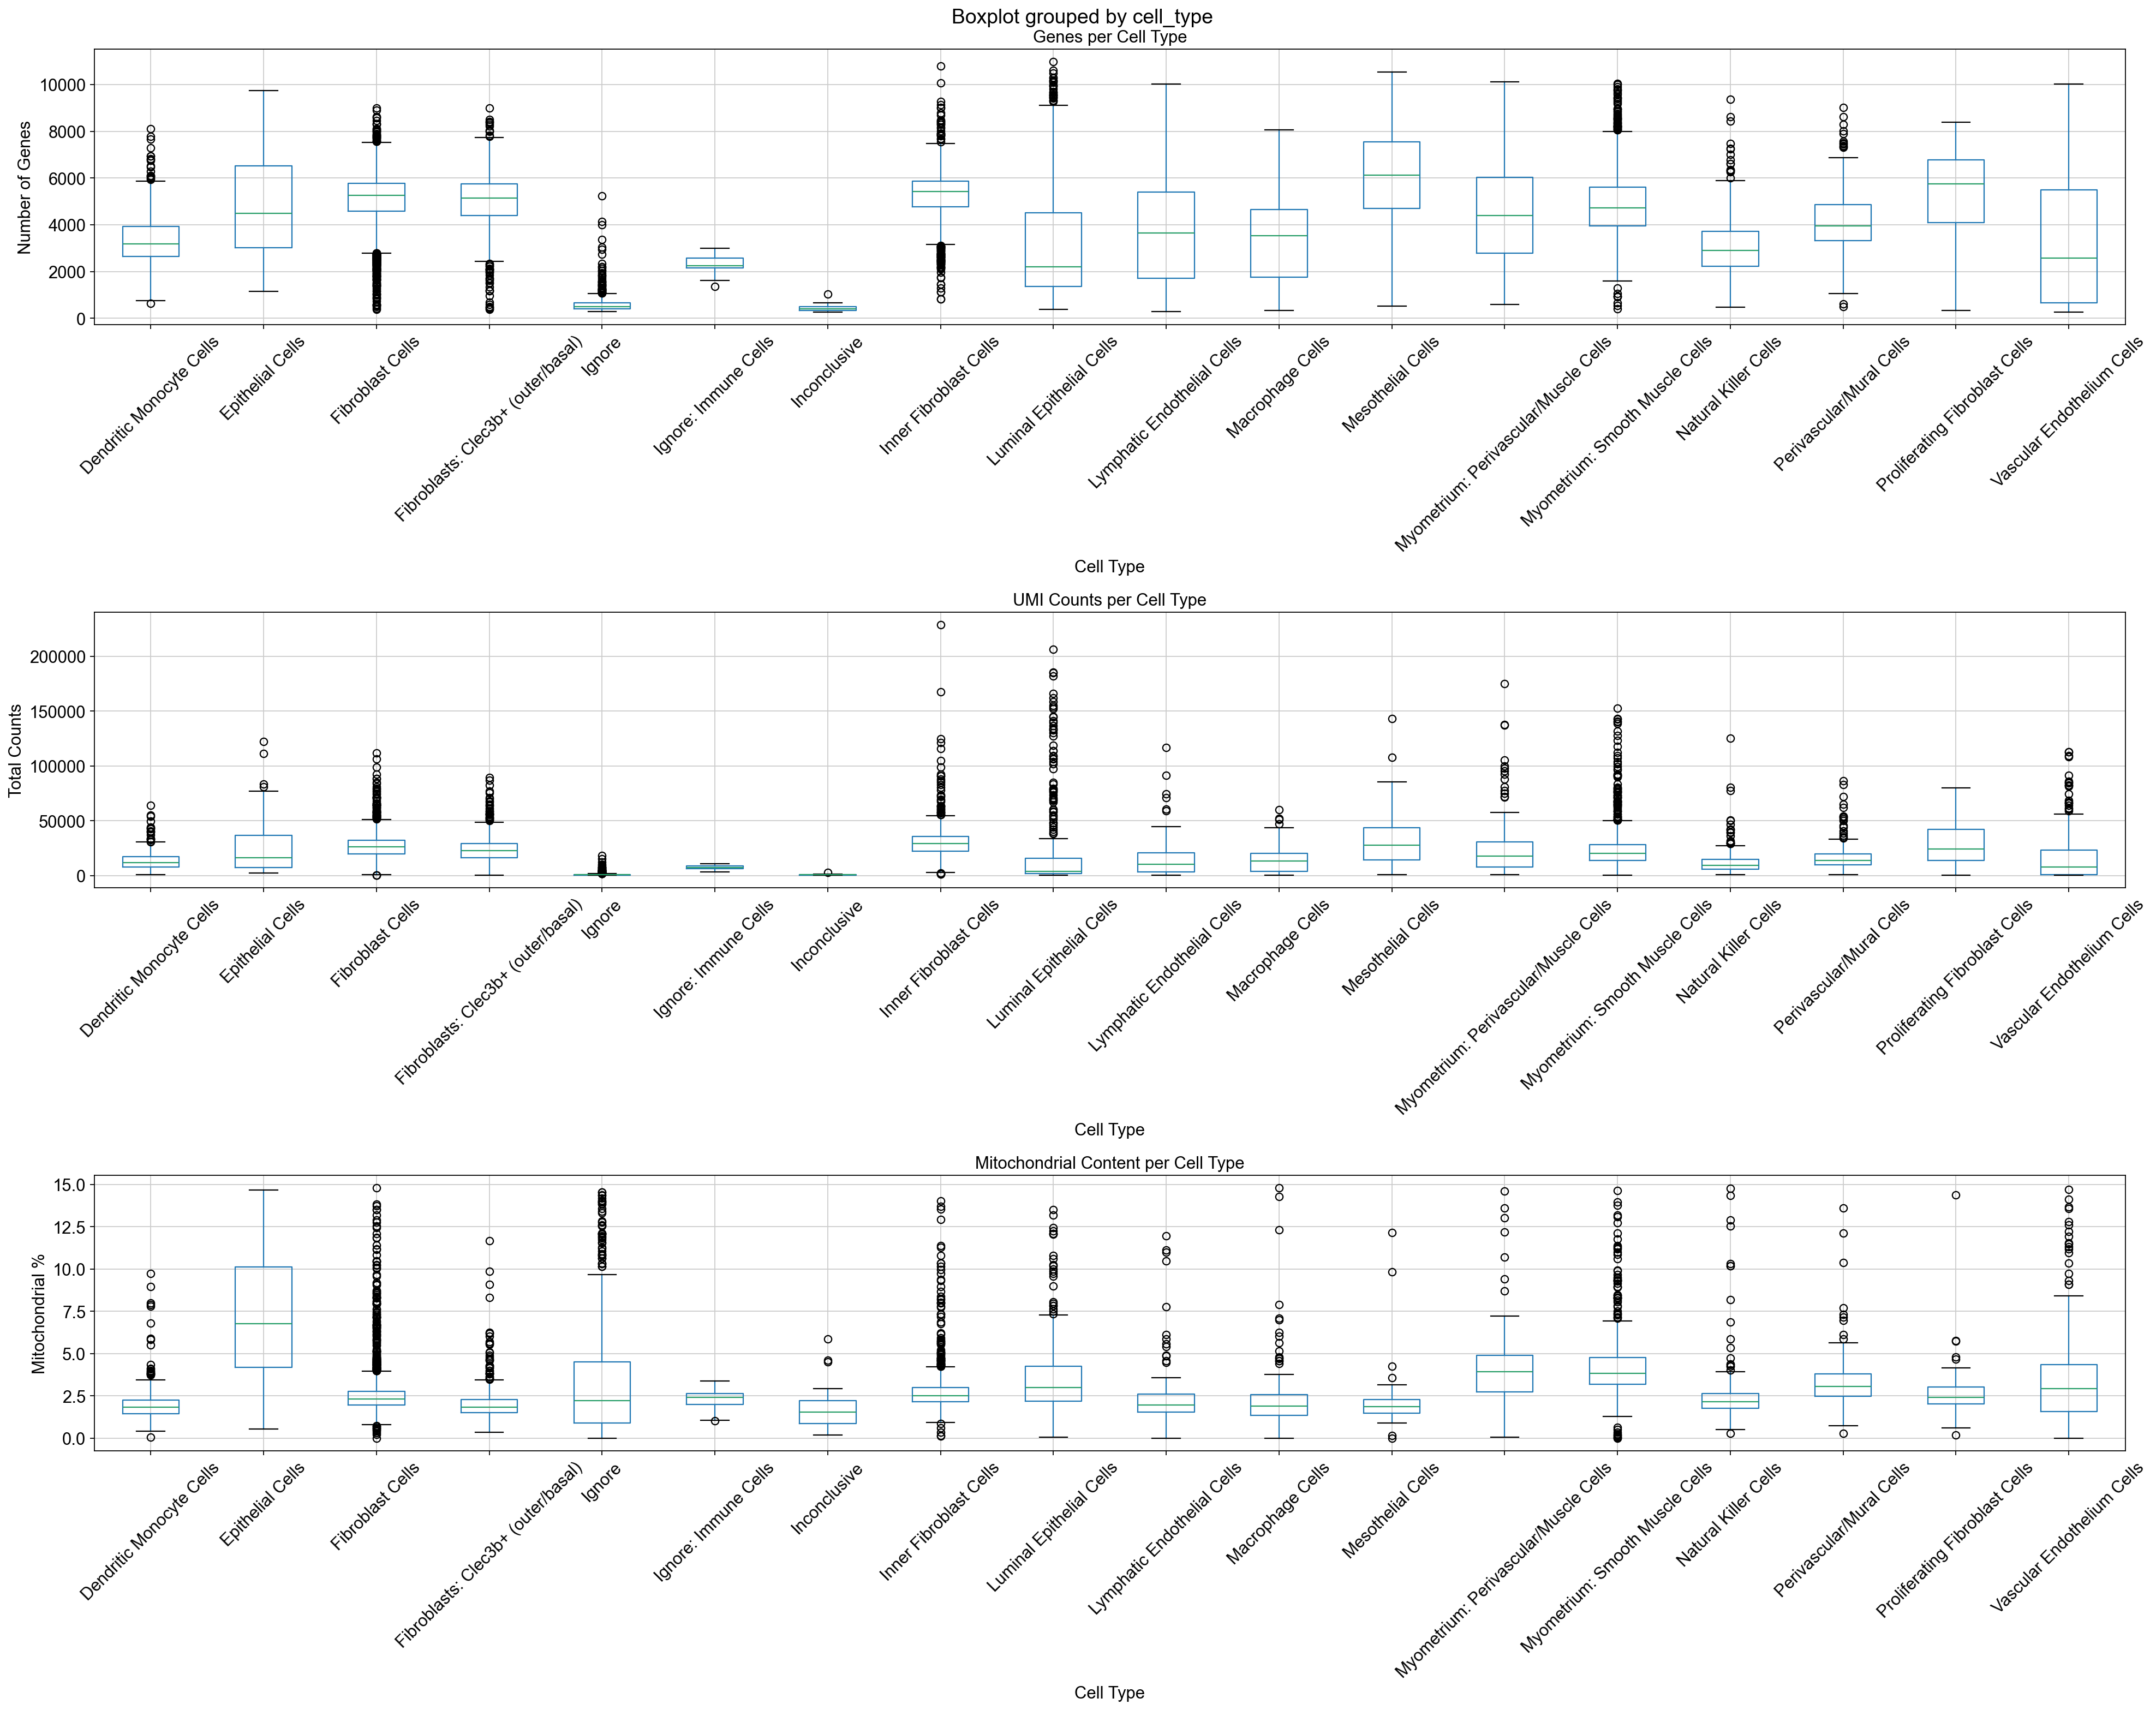

In [73]:
# Compare QC metrics across cell types
fig, axes = plt.subplots(3, 1, figsize=(25, 20))

# Number of genes
adata.obs.boxplot('n_genes_by_counts', by='cell_type', ax=axes[0])
axes[0].set_xlabel('Cell Type')
axes[0].set_ylabel('Number of Genes')
axes[0].set_title('Genes per Cell Type')
axes[0].tick_params(axis='x', rotation=45)

# Total counts
adata.obs.boxplot('total_counts', by='cell_type', ax=axes[1])
axes[1].set_xlabel('Cell Type')
axes[1].set_ylabel('Total Counts')
axes[1].set_title('UMI Counts per Cell Type')
axes[1].tick_params(axis='x', rotation=45)

# Mitochondrial percentage
adata.obs.boxplot('pct_counts_mt', by='cell_type', ax=axes[2])
axes[2].set_xlabel('Cell Type')
axes[2].set_ylabel('Mitochondrial %')
axes[2].set_title('Mitochondrial Content per Cell Type')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Save Annotated Data

In [70]:
# Save annotated data
output_file = '../data/processed/annotated_data.h5ad'
adata.write(output_file, compression='gzip')

print(f"Saved annotated data to {output_file}")
print(f"Dataset: {adata.shape[0]} cells x {adata.shape[1]} genes")
print(f"Cell types: {adata.obs['cell_type'].nunique()}")

Saved annotated data to ../data/processed/annotated_data.h5ad
Dataset: 7839 cells x 23542 genes
Cell types: 18


In [94]:
# Filter genes by those used in scFEA analysis
scfea_genes = pd.read_csv('../data/reference/scFEA_metabolic_genes.csv', header=0).iloc[:, 0].tolist()
print(f"Total scFEA genes in reference: {len(scfea_genes)}")
print(f"First 20 scFEA genes: {scfea_genes[:20]}")

# expr_df_transposed has genes as ROWS (index), cells as COLUMNS
print(f"\nExpression matrix structure:")
print(f"  Shape: {expr_df_transposed.shape}")
print(f"  Index (genes): {len(expr_df_transposed.index)}")
print(f"  Columns (cells): {len(expr_df_transposed.columns)}")

genes_in_data = [g for g in scfea_genes if g in expr_df_transposed.index]
print(f"\nMatching genes found in expression matrix: {len(genes_in_data)}")

# Filter expression matrix to only include scFEA genes (select rows)
expr_df_filtered = expr_df_transposed.loc[genes_in_data, :].copy()
print(f"\nFiltered expression matrix shape: {expr_df_filtered.shape}")

# Save filtered expression matrix
expr_df_filtered.to_csv('../data/processed/expr_mtx_scFEA_genes.csv')
print("Filtered expression matrix saved to '../data/processed/expr_mtx_scFEA_genes.csv'")

Total scFEA genes in reference: 719
First 20 scFEA genes: ['2410015N17Rik', '2410018C20Rik', '4631427C17Rik', '4732435N03Rik', '4833446K15Rik', 'A030007L17Rik', 'A530050D06Rik', 'Aacs', 'Aadat', 'Aass', 'Abat', 'Abo', 'Acaa1a', 'Acaa1b', 'Acaa2', 'Acaca', 'Acacb', 'Acad8', 'Acadl', 'Acadm']

Expression matrix structure:
  Shape: (23542, 7839)
  Index (genes): 23542
  Columns (cells): 7839

Matching genes found in expression matrix: 612

Filtered expression matrix shape: (612, 7839)
Filtered expression matrix saved to '../data/processed/expr_mtx_scFEA_genes.csv'


## Next Steps

Proceed to notebook `03_flux_estimation.ipynb` for metabolic flux analysis.